# Table of Contents
* <a href='#1'>1. Cluster based on manual segmentation results</a>

* <a href='#2'>2. Shape-based bayesian online disaggregation method</a>

    * <a href='#2.1'>2.1 More serious clustering on shapes</a>

    * <a href='#2.2'>2.2 Disaggregation algorithm and parameter tuning</a>




In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
import os
import sys

new_search_path = os.path.abspath('../../disaggregation')
if new_search_path not in sys.path: # not in PATH
    sys.path.insert(1, new_search_path)
# print sys.path

<a id='1'></a>
## 1. Cluster based on manual segmentation results

** a function to read data that is downloaded by me **

In [3]:
from os import path
import datetime

In [4]:
def read_dat_0819(date, h_start, h_end, folder_path):
    t = []
    dat = []
    start_time = None
    for h in range(h_start, h_end):
        try:
            file_name = '%d-%d-%d.csv' % (date.month, date.day, h)
            file_path = path.join(folder_path, file_name)
            data_pd = pd.read_csv(file_path, names=['time', 'data'])
            time_tmp = pd.to_datetime(data_pd.time,infer_datetime_format=True)
            if not start_time:
                start_time = time_tmp[0]
            tmp = [(x - start_time).seconds/3600. for x in time_tmp]
            t.extend(tmp)
            dat.extend( [x/3 for x in data_pd.data] )
        except Exception as inst:
            print type(inst), inst.args, inst     # the exception instance
            print '%s failed' % file_path
    return t, dat

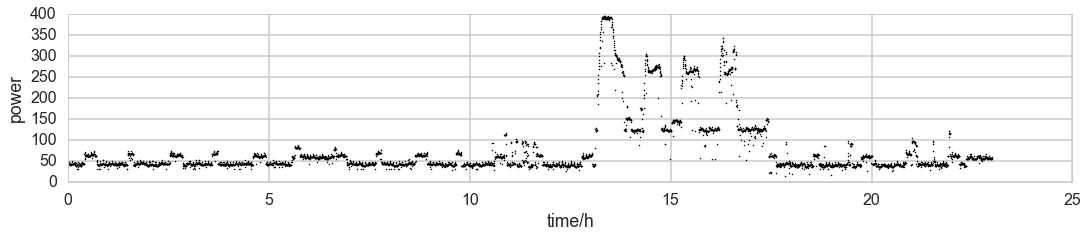

In [5]:
# example of read_dat_0819

t, dat = read_dat_0819(datetime.date(2016,4,1), 0, 23, '../new_data/IHG')

plt.figure(figsize=[18,3])
plt.plot(t, dat, 'k.', markersize=3)
plt.xlabel('time/h')
plt.ylabel('power')

** write a function that load manual change point **

In [6]:
def read_cp_0819(filepath):
    with open(filepath, 'r') as fid:
        return [float(x.strip()) for x in fid.readlines()]

In [7]:
# example to run read_cp_0819
print read_cp_0819('../results/4_1_manual_seg.txt')

[13.116667, 13.8375, 14.316667, 14.758333, 15.258333, 15.695833, 16.2, 16.629167, 17.433333]


In [8]:
print len(read_cp_0819('../results/4_3_manual_seg.txt'))

67


(0, 500)

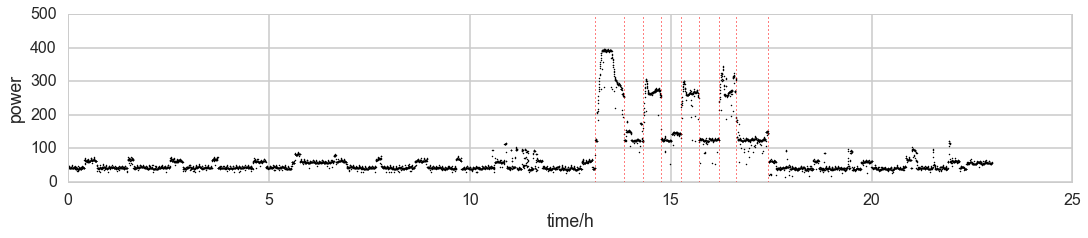

In [9]:
# now overlay raw data and manually draw change points

t, dat = read_dat_0819(datetime.date(2016,4,1), 0, 23, '../new_data/IHG')

plt.figure(figsize=[18,3])
plt.plot(t, dat, 'k.', markersize=3)
for cp in read_cp_0819('../results/4_1_manual_seg.txt'):
    plt.plot([cp,cp], [0,500], 'r:', linewidth=1)

plt.xlabel('time/h')
plt.ylabel('power')
plt.ylim([0, 500])

** write a function that list all files that are manual segmentation files **

these files are in results folder and have the format as [month]_[day]_manual_seg.txt

In [10]:
import os
import re

available_manual_seg_dates = [(re.split('_', x)[:2], x)
                              for x in os.listdir("../results") 
                              if re.match('.*_manual_seg.txt', x)
                             ]

print available_manual_seg_dates # first element is month, second is day

[(['4', '1'], '4_1_manual_seg.txt'), (['4', '2'], '4_2_manual_seg.txt'), (['4', '3'], '4_3_manual_seg.txt')]


** Align all segments **

In [11]:
all_dat_seg = []

for (m, d), cp_filepath in available_manual_seg_dates:
    t, dat = read_dat_0819(datetime.date(2016,int(m),int(d)), 0, 23, '../new_data/IHG')
    cp = read_cp_0819( os.path.join('../results', cp_filepath) )
    cp_interval = [int((x-t[0])/(t[1]-t[0])) for x in cp]
    cp_index_list = [i for i, x in enumerate(t) if int((x-t[0])/(t[1]-t[0])) in cp_interval]
    
    cp_index_list.append(len(t)-1) # append the last point as the end of last change point
    for i_segment in range(len(cp_index_list)-1):
        seg_start = cp_index_list[i_segment]+1
        seg_end = cp_index_list[i_segment+1]
        dat_seg = dat[seg_start:seg_end]
        all_dat_seg.append(
            {'dat_seg': dat_seg, 
             'last_data_before_cp': dat[seg_start-1], 
             'last_data_before_cp_3': dat[seg_start-3:seg_start]}
            )


(0, 50)

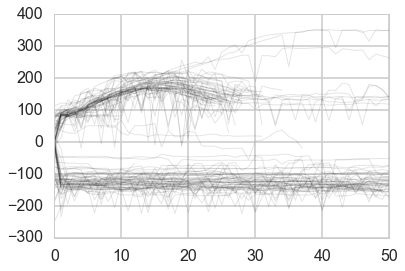

In [12]:
plt.figure(figsize=[6,4])
for seg in all_dat_seg:
    plt.plot( np.array(seg['dat_seg'])-np.mean(seg['last_data_before_cp_3']), 'k-', alpha=.1, linewidth=1)
plt.xlim([0,50])

** Conclusions: **

* manual segmentation yield similar results to the rough segmentation used previously

* sometimes manual segmentation shift the changepoint by one unit, as seen in the plot above. In this case, it is worse than the rough method used before. 

** In summary, previous clustering method is actually not bad, comparing to my manual change point detection **
 

<a id='2'></a>
## 2. Shape-based bayesian online disaggregation method

<a id='2.1'></a>
### 2.1 More serious clustering to get shapes

** write a function to filter bad data based on relative change **

In [13]:
def rel_change(y):
    """
    return relative change comparing to the closer neighbouring points
    """
    return np.min([np.abs(y[1] - y[0]), np.abs(y[1] - y[2])]) / float(y[1])

def rel_change_filter_0819(t, data_input, thre=.2):
    """
    filter data based on relative change
    data points in data_input that below or above both neighbouring points
    and have relative change above thre will be set as nan.
    """
    thre_2 = thre/(1-thre)
    id_filter = [i for i in range(1, len(data_input)-1) 
     if (data_input[i]>data_input[i-1] and data_input[i]>data_input[i+1] and rel_change(data_input[i-1:i+2])>thre) or
                 (data_input[i]<data_input[i-1] and data_input[i]<data_input[i+1] and rel_change(data_input[i-1:i+2])>thre_2)
    ]
    data_input_2 = [np.nan if i in id_filter else dat for i, dat in enumerate(data_input) ]
    return t, data_input_2

def rel_change_filter_0819_2(t, data_input, thre=.2):
    """
    filter data based on relative change
    data points in data_input that below or above both neighbouring points
    and have relative change above thre will be removed.
    """
    thre_2 = thre/(1-thre)
    id_filter = [i for i in range(1, len(data_input)-1) 
     if (data_input[i]>data_input[i-1] and data_input[i]>data_input[i+1] and rel_change(data_input[i-1:i+2])>thre) or
                 (data_input[i]<data_input[i-1] and data_input[i]<data_input[i+1] and rel_change(data_input[i-1:i+2])>thre_2)
    ]

    id_filter2 = np.setdiff1d(range(len(data_input)), id_filter)
    t_2 = [t[i] for i in id_filter2]
    data_input_2 = [data_input[i] for i in id_filter2]
    return t_2, data_input_2, id_filter2

def rel_change_filter_0819_3(t, data_input, thre=.2):
    """
    filter data based on relative change
    data points in data_input that below or above both neighbouring points
    and have relative change above thre will be set as the average of neighbouring data.
    """
    thre_2 = thre/(1-thre)
    id_filter = [i for i in range(1, len(data_input)-1) 
     if (data_input[i]>data_input[i-1] and data_input[i]>data_input[i+1] and rel_change(data_input[i-1:i+2])>thre) or
                 (data_input[i]<data_input[i-1] and data_input[i]<data_input[i+1] and rel_change(data_input[i-1:i+2])>thre_2)
    ]
    data_input_2 = [(data_input[i-1]+data_input[i+1])/2 if (i in id_filter) else dat for i, dat in enumerate(data_input) ]
    return t, data_input_2

In [14]:
# example

t = range(6)

print 'use rel_change_filter_0819'
y = [1,2,3,4,5,6]
print 'exmaple 1: ', (t,y), '->', rel_change_filter_0819(t,y)
y = [1,2,3,4,55,6] # abnormal data
print 'exmaple 2: ', (t,y), '->', rel_change_filter_0819(t,y)
y = [1, 10, 100, 1000, 10000] # fast changing data won't be removed
print 'exmaple 3: ', (t,y), '->', rel_change_filter_0819(t,y)

print
print 'use rel_change_filter_0819_2'
y = [1,2,3,4,5,6]
print 'exmaple 1: ', (t,y), '->', rel_change_filter_0819_2(t,y)
y = [1,2,3,4,55,6] # abnormal data
print 'exmaple 2: ', (t,y), '->', rel_change_filter_0819_2(t,y)
y = [1, 10, 100, 1000, 10000] # fast changing data won't be removed
print 'exmaple 3: ', (t,y), '->', rel_change_filter_0819_2(t,y)

print
print 'use rel_change_filter_0819_3'
y = [1,2,3,4,5,6]
print 'exmaple 1: ', (t,y), '->', rel_change_filter_0819_3(t,y)
y = [1,2,3,4,55,6] # abnormal data
print 'exmaple 2: ', (t,y), '->', rel_change_filter_0819_3(t,y)
y = [1, 10, 100, 1000, 10000] # fast changing data won't be removed
print 'exmaple 3: ', (t,y), '->', rel_change_filter_0819_3(t,y)

use rel_change_filter_0819
exmaple 1:  ([0, 1, 2, 3, 4, 5], [1, 2, 3, 4, 5, 6]) -> ([0, 1, 2, 3, 4, 5], [1, 2, 3, 4, 5, 6])
exmaple 2:  ([0, 1, 2, 3, 4, 5], [1, 2, 3, 4, 55, 6]) -> ([0, 1, 2, 3, 4, 5], [1, 2, 3, 4, nan, 6])
exmaple 3:  ([0, 1, 2, 3, 4, 5], [1, 10, 100, 1000, 10000]) -> ([0, 1, 2, 3, 4, 5], [1, 10, 100, 1000, 10000])

use rel_change_filter_0819_2
exmaple 1:  ([0, 1, 2, 3, 4, 5], [1, 2, 3, 4, 5, 6]) -> ([0, 1, 2, 3, 4, 5], [1, 2, 3, 4, 5, 6], array([0, 1, 2, 3, 4, 5]))
exmaple 2:  ([0, 1, 2, 3, 4, 5], [1, 2, 3, 4, 55, 6]) -> ([0, 1, 2, 3, 5], [1, 2, 3, 4, 6], array([0, 1, 2, 3, 5]))
exmaple 3:  ([0, 1, 2, 3, 4, 5], [1, 10, 100, 1000, 10000]) -> ([0, 1, 2, 3, 4], [1, 10, 100, 1000, 10000], array([0, 1, 2, 3, 4]))

use rel_change_filter_0819_3
exmaple 1:  ([0, 1, 2, 3, 4, 5], [1, 2, 3, 4, 5, 6]) -> ([0, 1, 2, 3, 4, 5], [1, 2, 3, 4, 5, 6])
exmaple 2:  ([0, 1, 2, 3, 4, 5], [1, 2, 3, 4, 55, 6]) -> ([0, 1, 2, 3, 4, 5], [1, 2, 3, 4, 5, 6])
exmaple 3:  ([0, 1, 2, 3, 4, 5], [1, 1

** load data in April, initial disaggregate and align **

In [15]:
from bayesian_cp_detect import cp_detect

In [16]:
def initial_disaggregate(date_start, date_end):
    
    date_current = date_start
    
    all_dat_seg = []
    while date_current < date_end:
        print 'reading: ', date_current

        t, y = read_dat_0819(date_current, 0, 23, '../new_data/IHG')
        t_2, y_2 = rel_change_filter_0819_3(t,y)
        mu_list_list, sigma_list_list, prob_r_list_list, r_list_list = cp_detect.bayesian_change_point_4(y_2, r_blur=30)
        changepoint, changepoint_p = cp_detect.get_change_point(prob_r_list_list)
        changepoint.append(len(t_2)-1)

        if len(changepoint)>1:
            dat_seg = [[y[cp_start:cp_end], y[cp_start-3:cp_start]] for cp_start, cp_end in zip(changepoint[:-1], changepoint[1:])]
        else:
            dat_seg = []
        all_dat_seg.extend(dat_seg)

        date_current+=datetime.timedelta(1)
        
    return all_dat_seg

In [17]:
all_seg_april = initial_disaggregate(datetime.date(2016,4,1), datetime.date(2016,5,1))

reading:  2016-04-01
reading:  2016-04-02
reading:  2016-04-03
reading:  2016-04-04
reading:  2016-04-05
reading:  2016-04-06
reading:  2016-04-07
reading:  2016-04-08
reading:  2016-04-09
reading:  2016-04-10
reading:  2016-04-11
reading:  2016-04-12
reading:  2016-04-13
reading:  2016-04-14
reading:  2016-04-15
reading:  2016-04-16
reading:  2016-04-17
reading:  2016-04-18
reading:  2016-04-19
reading:  2016-04-20
reading:  2016-04-21
reading:  2016-04-22
reading:  2016-04-23
reading:  2016-04-24
reading:  2016-04-25
reading:  2016-04-26
reading:  2016-04-27
reading:  2016-04-28
<type 'exceptions.IOError'> ('File ../new_data/IHG/4-28-4.csv does not exist',) File ../new_data/IHG/4-28-4.csv does not exist
../new_data/IHG/4-28-4.csv failed
reading:  2016-04-29
reading:  2016-04-30


In [19]:
import json

# with open('../metadata/seg in april 0822.json', 'w') as fid:
#     json.dump(all_seg_april, fid)

with open('../metadata/seg in april 0822.json', 'r') as fid:
    all_seg_april = json.load(fid)

** normalize by the last three data points **

In [20]:
all_seg_april_normalized = [np.array(x[0])-np.mean(x[1]) for x in all_seg_april if len(x[1])==3]

** plot all data **

(-200, 400)

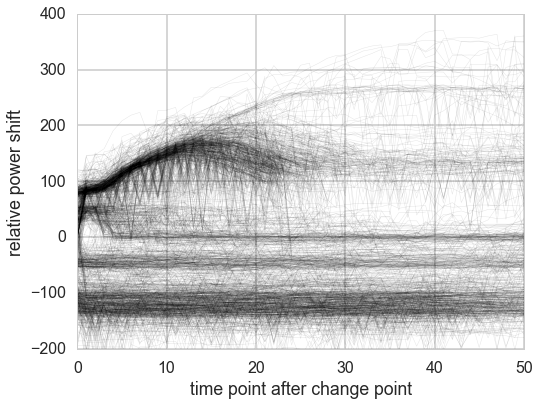

In [21]:
plt.figure(figsize=[8, 6])

for x in all_seg_april_normalized:
    plt.plot(x, 'k-', linewidth=.5, alpha=.1)

plt.xlabel('time point after change point')
plt.ylabel('relative power shift')
plt.xlim([0, 50])
plt.ylim([-200, 400])

## cluster

In [22]:
color_list = sns.color_palette("hls", 8)

In [23]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

** cluster using the first 50 data points **

In [24]:
# define a function that trim the first n data points, or discard if len is less

def extract_first_n(data_list, n):
    return [t[:n] for t in data_list if len(t)>=n]

In [25]:
all_seg_april_normalized_trim50 = extract_first_n(all_seg_april_normalized, 50)

print '# segs before trimming: ', len(all_seg_april_normalized)
print '# segs after trimming: ', len(all_seg_april_normalized_trim50)

n_clusters=6
y_pred = KMeans(n_clusters=6).fit_predict(all_seg_april_normalized_trim50)

cluster_average = []
for i_cluster in range(n_clusters):
    cluster_average.append(
        np.mean([np.mean(x) for i, x in enumerate(all_seg_april_normalized_trim50) if y_pred[i]==i_cluster])
    ) 

cluster_average_rank = np.argsort(cluster_average)[::-1]
rank_map = {cluster_average_rank[i_cluster]:i_cluster for i_cluster in range(n_clusters)} # old index:new index

y_pred_old = y_pred
y_pred = [rank_map[x] for x in y_pred]

# segs before trimming:  1447
# segs after trimming:  548


In [26]:
all_seg_per_cluster = [[] for i in range(n_clusters) ]
for i_seg in range(len(all_seg_april_normalized_trim50)):
    all_seg_per_cluster[y_pred[i_seg]].append(all_seg_april_normalized_trim50[i_seg])

In [27]:
cluster_mean = [[] for i in range(n_clusters) ]
cluster_std = [[] for i in range(n_clusters) ]
for i_cluster in range(n_clusters):
    cluster_mean[ i_cluster ] = np.mean(np.array(all_seg_per_cluster[i_cluster]), axis=0)
    cluster_std[ i_cluster ] = np.std(np.array(all_seg_per_cluster[i_cluster]), axis=0)

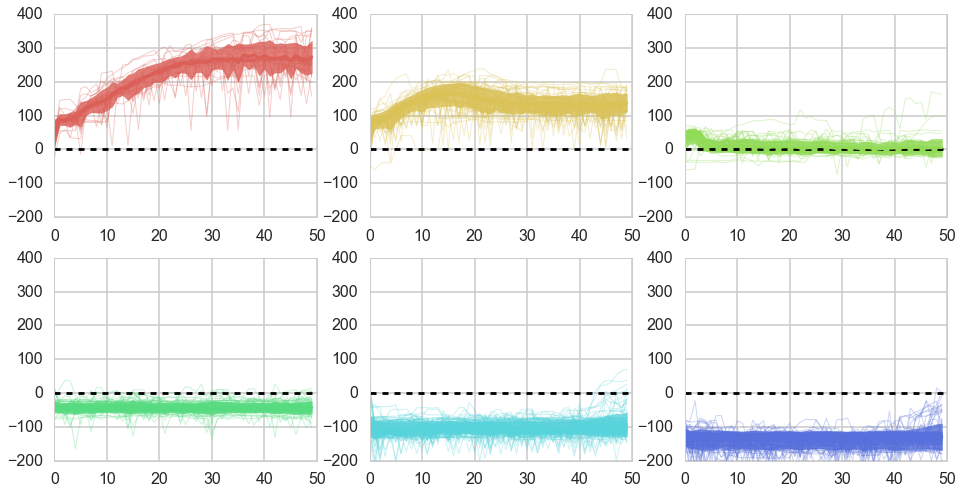

In [28]:
fig, ax = plt.subplots(nrows=2,ncols=3,figsize=[16,8]);
ax = ax.flatten()

for i_cluster in range(n_clusters):
    ax_current = ax[i_cluster]
    
    for seg in all_seg_per_cluster[i_cluster]:
        ax_current.plot(seg, '-', linewidth=1, alpha=.3, color=color_list[i_cluster])
    ax_current.set_xlim([0, 50])
    ax_current.set_ylim([-200, 400])
    ax_current.plot([0,50], [0,0], 'k--')    
    ax_current.plot(cluster_mean[i_cluster], color=color_list[i_cluster])
    ax_current.fill_between(range(50)
                            , cluster_mean[i_cluster]-cluster_std[i_cluster]
                            , cluster_mean[i_cluster]+cluster_std[i_cluster]
                            , color=color_list[i_cluster], alpha=.8)


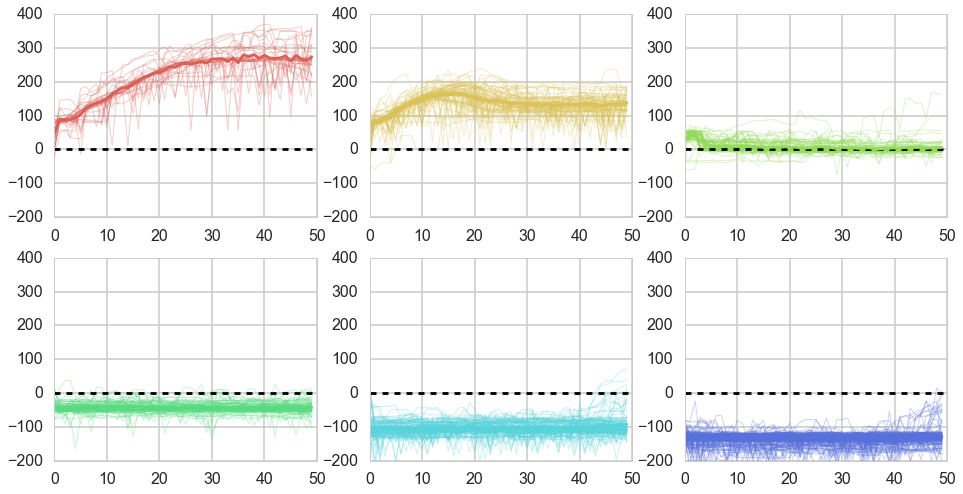

In [29]:
fig, ax = plt.subplots(nrows=2,ncols=3,figsize=[16,8]);
ax = ax.flatten()

for i_cluster in range(n_clusters):
    ax_current = ax[i_cluster]
    
    for seg in all_seg_per_cluster[i_cluster]:
        ax_current.plot(seg, '-', linewidth=1, alpha=.3, color=color_list[i_cluster])
    ax_current.set_xlim([0, 50])
    ax_current.set_ylim([-200, 400])
    ax_current.plot([0,50], [0,0], 'k--')    
    ax_current.plot(cluster_mean[i_cluster], color=color_list[i_cluster])


<a id='2.2'></a>
### 2.2 Disaggregation algorithm and parameter tuning

Let us test the idea to combine information from the learned shape and bayesian-style online detection method.
The idea is simple, for whatever method, when applied to individual segments above, should match the correct 
clustering results.

This means that, we need a disaggregate function, which takes in a series of data, return a set of change points. Since the inputs are relative simple compared to realistic data, I expect a reasonable disaggregation algorithm
will return a result that match to clustering results. 
The results depend on a set of parameters. This step idealy will be very useful to tune parameters.

function: disaggregate(data, parameter=default_parameter)
<pre>
```python
for data in all_data:
    cp = disaggregate(data)
    mistake = compare_cp_to_cluster( cp, predict_cluster(data) )
```
</pre>
The idea is to find **default_parameter** that minimize mistakes.

** Disaggregation algorithm **

After time *t*, let us imagine that we use the following summary statistics to summarize information for all previous data $y_{1:t}$.

* $P(s_i, \tau|y_{1:t})$, the probability of the last change point is due to type i change, and it happened at $t-\tau$.
$\tau$ can only be zero or positive. When it is zero, it means that the current time t is the first time point 
after change.

* $\Delta_{mean}(s_i, \tau|y_{1:t})$ and $\Delta_{var}(s_i, \tau|y_{1:t})$, 
mean and variance of the relative shift compared to the average shape.

Image we get a new data point $y_{t+1}$, we want to get the corresponding $P(..|y_{1:t+1})$, $\Delta_{mean}(..|y_{1:t+1})$, and $\Delta_{var}(..|y_{1:t+1})$

We do this by using a method similar to Kalman Filter in two steps. 
* In the prediction step, we use what is known about the shape to predict the three number of the next data point
without knowing $y_{t+1}$
* In the udpate step, we combine the previous knowledge with the new measurement.

**Step 1 in prediction step:**

$P^{t+1}(s_i, \tau | y_{1:t}) = H(s_i, \tau-1) * P^{t}(s_i, \tau-1 | y_{1:t})$, for $\tau$>0

$P^{t+1}(s_i, \tau | y_{1:t}) = P_0$, for $\tau$=0

P_0 used the assumption that all change point types are equally possible, which can be changed later. 

P_0 also makes sure that all probs can be summed to be 1

0 < H < 1, is the probability that shape i at $\tau$ will not change in the next time point. In the simplest case,
we can assume that it is the same for all shapes and $\tau$, but in principle this can be learnt in the history data.

**Step 2 in prediction step:**

$\Delta^{t+1}_{mean}(s_i, \tau|y_{1:t}) = \Delta^{t}_{mean}(s_i, \tau-1|y_{1:t}) + shape_i(\tau)-shape_i(\tau-1)$
for $\tau$ > 0. This assumes $shape_i(0-1) = 0$.

$\Delta^{t+1}_{mean}(s_i, \tau|y_{1:t}) = shape_i( 0 )$ for $\tau=0$

$\Delta^{t+1}_{var}(s_i, \tau|y_{1:t}) = \Delta^{t}_{var}(s_i, \tau-1|y{1:t}) + \delta_i(\tau)+Q$, 
for \tau > 0. Here $\delta$ is due to uncertainty in estimating change in average shape, which is defined as

$\delta_i = E(\delta_i(\tau)) = E (std(y(i,\tau))/\sqrt{(N_{sample})})$

Q is the process variance, a free parameter.

$\Delta^{t+1}_{var}(s_i, \tau|y_{1:t}) = \Delta_{init}$, $\Delta_{init}$ is a free parameter.

** Estimate prob **

$P_{pred}(s_i, \tau) = P(y_{t+1}|\mu=\Delta^{t+1}_{mean}(s_i, \tau|y_{1:t}),var=\Delta^{t+1}_{var}(s_i, \tau|y_{1:t})+R)$, 
R is the variance of measurement noise.

P will tells us how different new measurement is different from previous measurement

** Update step **

Kalman coefficient: $K = \Delta^{t+1}_{var}(s_i, \tau|y_{1:t}) / (\Delta^{t+1}_{var}(s_i, \tau|y_{1:t})+R)$

Difference: $offset = y_{t+1}-\Delta^{t+1}_{mean}(s_i, \tau|y_{1:t})$

$\Delta^{t+1}_{mean}(s_i, \tau|y_{1:t+1}) = \Delta^{t+1}_{mean}(s_i, \tau|y_{1:t}) + K * offset$

$\Delta^{t+1}_{var}(s_i, \tau|y_{1:t+1}) = (1-K) * \Delta^{t+1}_{var}(s_i, \tau|y_{1:t})$

** Update prob **

$P^{t+1}(s_i, \tau|y_{1:t+1}) = 1/Z * P^{t}(s_i, \tau|y_{1:t}) * P_{pred}(s_i, \tau)$

or in log scale

$P_{log}^{t+1}(s_i, \tau|y_{1:t+1}) = -Z_{log} + P_{log}^{t}(s_i, \tau|y_{1:t}) + P_{log, pred}(s_i, \tau)$
, where Z is normalization factor

** define a helper function **

In [30]:
def log_norm_pdf(x
                 , mu
                 , sigma_2 # sigma^2
                ):
    return -(x-mu)**2/sigma_2 - np.log(2*np.pi*sigma_2)/2

In [31]:
# test log_norm_pdf
print log_norm_pdf(0,0,1)

-0.918938533205


** find out the error when estimating shape variance **

In [32]:
delta_shape = [[] for i in range(n_clusters)]

for i_cluster in range(n_clusters):
    delta_shape[i_cluster] = 2*np.mean(cluster_std[i_cluster]**2 / len(all_seg_per_cluster[i_cluster]))
    print 'shape %d, average change std %1.1f' % \
    (i_cluster, 
     np.sqrt(delta_shape[i_cluster]))

shape 0, average change std 8.8
shape 1, average change std 5.0
shape 2, average change std 3.3
shape 3, average change std 2.3
shape 4, average change std 2.7
shape 5, average change std 3.2


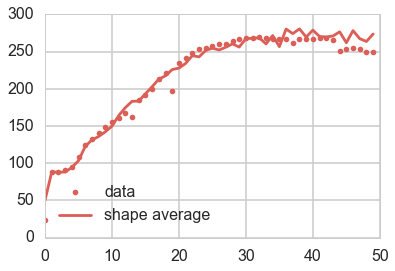

In [33]:
# example 

i_cluster = 0
i_seg = 1

data = all_seg_per_cluster[i_cluster][i_seg]
_, data = rel_change_filter_0819_3(range(len(data)), data)

plt.figure(figsize=[6,4])
plt.plot(data, '.', color=color_list[i_cluster], label='data')
plt.plot(cluster_mean[i_cluster], color=color_list[i_cluster], label='shape average')
plt.legend(loc=0)

For update, we are going to write something like this

<pre>
```python
log_prob, delta_mean, delta_var = set_prior(para)
for datum in data:
    log_prob, delta_mean, delta_var = update(datum, log_prob, delta_mean, delta_var)
```
</pre>
We can then check how log_prob changes

In [34]:
def set_prior(para):
    n_shape = para['n_shape']
#     log_prob = [ [np.log(1./n_shape)] for i_shape in range(n_shape) ]
#     delta_mean = [ [0] for i_shape in range(n_shape) ]
#     delta_var = [ [para['delta_init']] for i_shape in range(n_shape) ]
    log_prob = [ [] for i_shape in range(n_shape) ]
    delta_mean = [ [] for i_shape in range(n_shape) ]
    delta_var = [ [] for i_shape in range(n_shape) ]
    return log_prob, delta_mean, delta_var
    
def update_with_datum(datum, log_prob, delta_mean, delta_var, last_datum, para):
    
    n_shape = para['n_shape']
    H = para['H']
    H_2_exp = 1-np.exp(H)
    delta_shape = para['delta_shape']
    Q = para['Q']
    R = para['R']
    shape = para['shape']

    # step 1
    log_prob_grow = [ [] for _ in range(n_shape) ]
    for i_shape in range(n_shape):
        log_prob_grow[i_shape] = [np.log(H_2_exp*1./n_shape)] + [x + H for x in log_prob[i_shape]]
    
    # step 2
    delta_mean_grow = [ [] for _ in range(n_shape) ]
    delta_var_grow = [ [] for _ in range(n_shape) ]
    for i_shape in range(n_shape):
        delta_mean_grow[i_shape] = [last_datum+shape[i_shape][0]] + [x+shape[i_shape][i+1] for i, x in enumerate(delta_mean[i_shape]) ]
        delta_var_grow[i_shape] = [para['delta_init']] + [x+delta_shape[i_shape]+Q for x in delta_var[i_shape]]
    
    # estimate probability
    p_predict = [ [ ] for i_shape in range(n_shape) ]
    for i_shape in range(n_shape):
        n_tau = len(delta_mean_grow[i_shape])
        tmp = [ 0 for _ in range(n_tau) ]
        for i_tau in range(n_tau):
            tmp[i_tau] = log_norm_pdf( datum, delta_mean_grow[i_shape][i_tau], delta_var_grow[i_shape][i_tau] + R )
        p_predict[i_shape] = tmp
    
    # Update step
    delta_mean_posterior = [ [] for _ in range(n_shape)]
    delta_var_posterior = [ [] for _ in range(n_shape) ]
    for i_shape in range(n_shape):
        n_tau = len(delta_mean_grow[i_shape])
        delta_mean_tmp = [ [] for _ in range(n_tau) ]
        delta_var_tmp = [ [] for _ in range(n_tau) ]
        for i_tau in range(n_tau):
            K = delta_var_grow[i_shape][i_tau] / (delta_var_grow[i_shape][i_tau]+R)
            offset = datum - delta_mean_grow[i_shape][i_tau]
            delta_mean_tmp[i_tau] = delta_mean_grow[i_shape][i_tau] + K * offset
            delta_var_tmp[i_tau] = (1-K) * delta_var_grow[i_shape][i_tau]
        delta_mean_posterior[i_shape] = delta_mean_tmp
        delta_var_posterior[i_shape] = delta_var_tmp
            
    # update prob
    log_prob_posterior = [ [] for _ in range(n_shape) ]
    for i_shape in range(n_shape):
        log_prob_posterior[i_shape] = [x+y for x,y in zip(log_prob_grow[i_shape], p_predict[i_shape])]
    Z = sp.misc.logsumexp(log_prob_posterior)
    for i_shape in range(n_shape):
        log_prob_posterior[i_shape] = [x-Z for x in log_prob_posterior[i_shape]]
        
    # discount mean
    for i_shape in range(n_shape):
        delta_mean_posterior[i_shape] = [x-shape[i_shape][i] for i,x in enumerate(delta_mean_posterior[i_shape])]
    
    return log_prob_posterior, delta_mean_posterior, delta_var_posterior

In [35]:
para = {}
para['n_shape'] = n_clusters
para['delta_init'] = 200.
para['H'] = np.log(1-1./(15*4)) # 15 min per cp
para['delta_shape'] = delta_shape
para['Q'] = 100. # process error
para['R'] = 100. # measurement error
para['shape'] = cluster_mean

In [36]:
%%time
log_prob, delta_mean, delta_var = set_prior(para)
last_datum = 0

log_prob_list = []
delta_mean_list = []
delta_var_list = []

for datum in data:
    log_prob, delta_mean, delta_var = update_with_datum(datum, log_prob, delta_mean, delta_var, last_datum, para)
    last_datum = datum
    
    log_prob_list.append(log_prob)
    delta_mean_list.append(delta_mean)
    delta_var_list.append(delta_var)
    

CPU times: user 133 ms, sys: 4.43 ms, total: 138 ms
Wall time: 220 ms


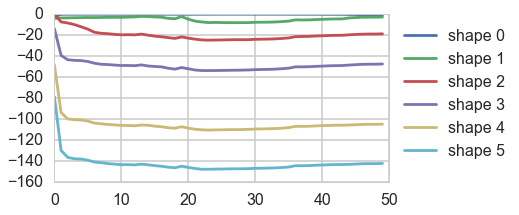

In [37]:
plt.figure(figsize=[6,3])
for i_shape in range(n_clusters):
    plt.plot([x[i_shape][-1] for x in log_prob_list], label='shape '+str(i_shape))
# plt.ylim([-20, 0])
plt.legend(loc=0,bbox_to_anchor=[1,1])

In [38]:
%%time

data = all_seg_per_cluster[0][5]
_, data = rel_change_filter_0819_3(range(len(data)), data)

log_prob, delta_mean, delta_var = set_prior(para)
last_datum = 0

log_prob_list = []
delta_mean_list = []
delta_var_list = []

for datum in data:
    log_prob, delta_mean, delta_var = update_with_datum(datum, log_prob, delta_mean, delta_var, last_datum, para)
    last_datum = datum
    
    log_prob_list.append(log_prob)
    delta_mean_list.append(delta_mean)
    delta_var_list.append(delta_var)
    

CPU times: user 133 ms, sys: 1.71 ms, total: 134 ms
Wall time: 253 ms


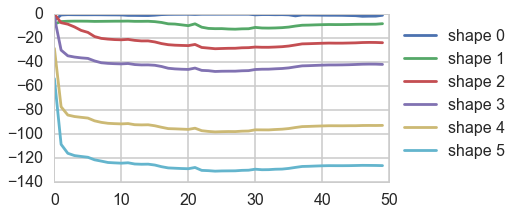

In [39]:
plt.figure(figsize=[6,3])
for i_shape in range(n_clusters):
    plt.plot([x[i_shape][-1] for x in log_prob_list], label='shape '+str(i_shape))
# plt.ylim([-20, 0])
plt.legend(loc=0,bbox_to_anchor=[1,1])

In [50]:
max_arg_max = lambda x: (np.argmax(x), np.max(x))

seg_result = []

for i_cluster in range(n_clusters):
    seg_result_tmp = []
    print i_cluster
    for i_seg, seg in enumerate(all_seg_per_cluster[i_cluster]):
        data = seg
        _, data = rel_change_filter_0819_3(range(len(data)), data)

        log_prob, delta_mean, delta_var = set_prior(para)
        last_datum = 0

        log_prob_list = []
        delta_mean_list = []
        delta_var_list = []

        for datum in data:
            log_prob, delta_mean, delta_var = update_with_datum(datum, log_prob, delta_mean, delta_var, last_datum, para)
            last_datum = datum

            log_prob_list.append(log_prob)
            delta_mean_list.append(delta_mean)
            delta_var_list.append(delta_var)

        seg_result_tmp.append([i_seg, max_arg_max([x[-1] for x in log_prob_list[-1]])])
    seg_result.append(seg_result_tmp)

0
1
2
3
4
5


In [78]:
# count the number of mistakes that we make

error_dict = {(i,j):0 for i in range(n_clusters) for j in range(n_clusters)}
for i_cluster in range(n_clusters):
    for x in seg_result[i_cluster]:
        error_dict[(i_cluster, x[1][0]) ] += 1

for i in range(n_clusters):
    for j in range(n_clusters):
        print i,'->',j,': ',error_dict[(i,j)]
        
c = 0
for i in range(2):
    for j in range(n_clusters):
        if i != j:
            c+=error_dict[(i,j)]
            
print c

0 -> 0 :  24
0 -> 1 :  8
0 -> 2 :  0
0 -> 3 :  0
0 -> 4 :  0
0 -> 5 :  0
1 -> 0 :  9
1 -> 1 :  65
1 -> 2 :  0
1 -> 3 :  1
1 -> 4 :  0
1 -> 5 :  0
2 -> 0 :  0
2 -> 1 :  0
2 -> 2 :  67
2 -> 3 :  4
2 -> 4 :  0
2 -> 5 :  0
3 -> 0 :  0
3 -> 1 :  0
3 -> 2 :  1
3 -> 3 :  84
3 -> 4 :  1
3 -> 5 :  0
4 -> 0 :  0
4 -> 1 :  0
4 -> 2 :  0
4 -> 3 :  11
4 -> 4 :  94
4 -> 5 :  25
5 -> 0 :  0
5 -> 1 :  0
5 -> 2 :  0
5 -> 3 :  0
5 -> 4 :  20
5 -> 5 :  134
18


In [87]:
res = {}
for Q in [5,10,15,20]:
    Q = Q**2
    for R in [5,10,15,20]:
        R = R**2
        print Q, R
        para = {}
        para['n_shape'] = n_clusters
        para['delta_init'] = 200.
        para['H'] = np.log(1-1./(15*4)) # 15 min per cp
        para['delta_shape'] = delta_shape
        para['Q'] = float(Q) # process error
        para['R'] = float(R) # measurement error
        para['shape'] = cluster_mean

        max_arg_max = lambda x: (np.argmax(x), np.max(x))

        seg_result = []

        for i_cluster in range(n_clusters):
            seg_result_tmp = []
            for i_seg, seg in enumerate(all_seg_per_cluster[i_cluster]):
                data = seg
                _, data = rel_change_filter_0819_3(range(len(data)), data)

                log_prob, delta_mean, delta_var = set_prior(para)
                last_datum = 0

                log_prob_list = []
                delta_mean_list = []
                delta_var_list = []

                for datum in data:
                    log_prob, delta_mean, delta_var = update_with_datum(datum, log_prob, delta_mean, delta_var, last_datum, para)
                    last_datum = datum

                    log_prob_list.append(log_prob)
                    delta_mean_list.append(delta_mean)
                    delta_var_list.append(delta_var)

                seg_result_tmp.append([i_seg, max_arg_max([x[-1] for x in log_prob_list[-1]])])
            seg_result.append(seg_result_tmp)

        # count the number of mistakes that we make

        error_dict = {(i,j):0 for i in range(n_clusters) for j in range(n_clusters)}
        for i_cluster in range(n_clusters):
            for x in seg_result[i_cluster]:
                error_dict[(i_cluster, x[1][0]) ] += 1

        c = 0
        for i in range(2):
            for j in range(n_clusters):
                if i != j:
                    c+=error_dict[(i,j)]

        print c
        res[(Q, R)] = c

25 25
31
25 100
19
25 225
11
25 400
3
100 25
29
100 100
18
100 225
12
100 400
7
225 25
29
225 100
25
225 225
20
225 400
11
400 25
35
400 100
31
400 225
25
400 400
19


In [40]:
para = {}
para['n_shape'] = n_clusters
para['delta_init'] = 200.
para['H'] = np.log(1-1./(15*4)) # 15 min per cp
para['delta_shape'] = delta_shape
para['Q'] = 5.**2 # process error
para['R'] = 20.**2 # measurement error
para['shape'] = cluster_mean

max_arg_max = lambda x: (np.argmax(x), np.max(x))

seg_result = []

for i_cluster in range(n_clusters):
    seg_result_tmp = []
    for i_seg, seg in enumerate(all_seg_per_cluster[i_cluster]):
        data = seg
        _, data = rel_change_filter_0819_3(range(len(data)), data)

        log_prob, delta_mean, delta_var = set_prior(para)
        last_datum = 0

        log_prob_list = []
        delta_mean_list = []
        delta_var_list = []

        for datum in data:
            log_prob, delta_mean, delta_var = update_with_datum(datum, log_prob, delta_mean, delta_var, last_datum, para)
            last_datum = datum

            log_prob_list.append(log_prob)
            delta_mean_list.append(delta_mean)
            delta_var_list.append(delta_var)

        seg_result_tmp.append([i_seg, max_arg_max([x[-1] for x in log_prob_list[-1]])])
    seg_result.append(seg_result_tmp)
    
# count the number of mistakes that we make

error_dict = {(i,j):0 for i in range(n_clusters) for j in range(n_clusters)}
for i_cluster in range(n_clusters):
    for x in seg_result[i_cluster]:
        error_dict[(i_cluster, x[1][0]) ] += 1

for i in range(n_clusters):
    for j in range(n_clusters):
        print i,'->',j,': ',error_dict[(i,j)]
        
c = 0
for i in range(2):
    for j in range(n_clusters):
        if i != j:
            c+=error_dict[(i,j)]
            
print c

0 -> 0 :  31
0 -> 1 :  1
0 -> 2 :  0
0 -> 3 :  0
0 -> 4 :  0
0 -> 5 :  0
1 -> 0 :  2
1 -> 1 :  73
1 -> 2 :  0
1 -> 3 :  0
1 -> 4 :  0
1 -> 5 :  0
2 -> 0 :  0
2 -> 1 :  0
2 -> 2 :  67
2 -> 3 :  4
2 -> 4 :  0
2 -> 5 :  0
3 -> 0 :  0
3 -> 1 :  0
3 -> 2 :  1
3 -> 3 :  84
3 -> 4 :  1
3 -> 5 :  0
4 -> 0 :  0
4 -> 1 :  0
4 -> 2 :  0
4 -> 3 :  10
4 -> 4 :  103
4 -> 5 :  17
5 -> 0 :  0
5 -> 1 :  0
5 -> 2 :  0
5 -> 3 :  0
5 -> 4 :  20
5 -> 5 :  134
3


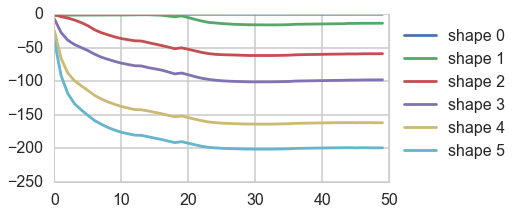

In [42]:
data = all_seg_per_cluster[0][1]

_, data = rel_change_filter_0819_3(range(len(data)), data)

log_prob, delta_mean, delta_var = set_prior(para)
last_datum = 0

log_prob_list = []
delta_mean_list = []
delta_var_list = []

for datum in data:
    log_prob, delta_mean, delta_var = update_with_datum(datum, log_prob, delta_mean, delta_var, last_datum, para)
    last_datum = datum

    log_prob_list.append(log_prob)
    delta_mean_list.append(delta_mean)
    delta_var_list.append(delta_var)

plt.figure(figsize=[6,3])
for i_shape in range(n_clusters):
    plt.plot([x[i_shape][-1] for x in log_prob_list], label='shape '+str(i_shape))
# plt.ylim([-20, 0])
plt.legend(loc=0,bbox_to_anchor=[1,1])

In [69]:
def set_prior_2(para):
    n_shape = para['n_shape']
#     log_prob = [ [np.log(1./n_shape)] for i_shape in range(n_shape) ]
#     delta_mean = [ [0] for i_shape in range(n_shape) ]
#     delta_var = [ [para['delta_init']] for i_shape in range(n_shape) ]
    log_prob = [ [] for i_shape in range(n_shape) ]
    delta_mean = [ [] for i_shape in range(n_shape) ]
    delta_var = [ [] for i_shape in range(n_shape) ]
    time_since_last_cp = [ [] for i_shape in range(n_shape) ]
    return log_prob, delta_mean, delta_var, time_since_last_cp
    
def update_with_datum_2(datum, log_prob, delta_mean, delta_var, time_since_last_cp, last_datum, para):
    
    n_shape = para['n_shape']
    H = para['H']
    H_2_exp = 1-np.exp(H)
    delta_shape = para['delta_shape']
    Q = para['Q']
    R = para['R']
    shape = para['shape']
    
    shape_helper = lambda i_shape, x: shape[i_shape][x] if x<len(shape[i_shape]) else shape[i_shape][-1]

    # step 1
    log_prob_grow = [ [] for _ in range(n_shape) ]
    time_since_last_cp_grow = [ [] for _ in range(n_shape) ]
    for i_shape in range(n_shape):
        log_prob_grow[i_shape] = [np.log(H_2_exp*1./n_shape)] + [x + H for x in log_prob[i_shape]]
        time_since_last_cp_grow[i_shape] = [0] + [x+1 for x in time_since_last_cp[i_shape]]

    # step 2
    delta_mean_grow = [ [] for _ in range(n_shape) ]
    delta_var_grow = [ [] for _ in range(n_shape) ]
    for i_shape in range(n_shape):
        delta_mean_grow[i_shape] = [shape_helper(i_shape, x)+y for x, y in zip(time_since_last_cp_grow[i_shape], [last_datum]+delta_mean[i_shape])]
#         delta_mean_grow[i_shape] = [last_datum+shape[i_shape][0]] + [x+shape[i_shape][i+1] for i, x in enumerate(delta_mean[i_shape]) ]
        delta_var_grow[i_shape] = [para['delta_init']] + [x+delta_shape[i_shape]+Q for x in delta_var[i_shape]]
    
    # estimate probability
    p_predict = [ [ ] for i_shape in range(n_shape) ]
    for i_shape in range(n_shape):
        n_tau = len(delta_mean_grow[i_shape])
        tmp = [ 0 for _ in range(n_tau) ]
        for i_tau in range(n_tau):
            tmp[i_tau] = log_norm_pdf( datum, delta_mean_grow[i_shape][i_tau], delta_var_grow[i_shape][i_tau] + R )
        p_predict[i_shape] = tmp
    
    # Update step
    delta_mean_posterior = [ [] for _ in range(n_shape)]
    delta_var_posterior = [ [] for _ in range(n_shape) ]
    for i_shape in range(n_shape):
        n_tau = len(delta_mean_grow[i_shape])
        delta_mean_tmp = [ [] for _ in range(n_tau) ]
        delta_var_tmp = [ [] for _ in range(n_tau) ]
        for i_tau in range(n_tau):
            K = delta_var_grow[i_shape][i_tau] / (delta_var_grow[i_shape][i_tau]+R)
            offset = datum - delta_mean_grow[i_shape][i_tau]
            delta_mean_tmp[i_tau] = delta_mean_grow[i_shape][i_tau] + K * offset
            delta_var_tmp[i_tau] = (1-K) * delta_var_grow[i_shape][i_tau]
        delta_mean_posterior[i_shape] = delta_mean_tmp
        delta_var_posterior[i_shape] = delta_var_tmp
            
    # update prob
    log_prob_posterior = [ [] for _ in range(n_shape) ]
    for i_shape in range(n_shape):
        log_prob_posterior[i_shape] = [x+y for x,y in zip(log_prob_grow[i_shape], p_predict[i_shape])]
    Z = sp.misc.logsumexp(log_prob_posterior)
    for i_shape in range(n_shape):
        log_prob_posterior[i_shape] = [x-Z for x in log_prob_posterior[i_shape]]
        
    # discount mean
    time_since_last_cp_posterior = time_since_last_cp_grow
    for i_shape in range(n_shape):
        delta_mean_posterior[i_shape] = [x-shape_helper(i_shape, y) for x, y in zip(delta_mean_posterior[i_shape], time_since_last_cp_posterior[i_shape])]
#         delta_mean_posterior[i_shape] = [x-shape[i_shape][i] for i,x in enumerate(delta_mean_posterior[i_shape])]

    return log_prob_posterior, delta_mean_posterior, delta_var_posterior, time_since_last_cp_posterior

In [73]:
%%time
data = all_seg_per_cluster[0][1]

_, data = rel_change_filter_0819_3(range(len(data)), data)

log_prob, delta_mean, delta_var, time_since_last_cp = set_prior_2(para)
last_datum = 0

log_prob_list = []
delta_mean_list = []
delta_var_list = []
time_since_last_cp_list = []

for datum in data:
    log_prob, delta_mean, delta_var, time_since_last_cp = update_with_datum_2(datum, log_prob, delta_mean, delta_var, time_since_last_cp, last_datum, para)
    last_datum = datum

    log_prob_list.append(log_prob)
    delta_mean_list.append(delta_mean)
    delta_var_list.append(delta_var)
    time_since_last_cp_list.append(time_since_last_cp)


CPU times: user 149 ms, sys: 1.54 ms, total: 150 ms
Wall time: 164 ms


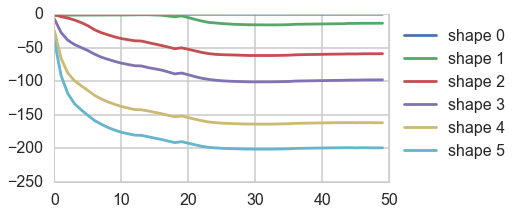

In [74]:
plt.figure(figsize=[6,3])
for i_shape in range(n_clusters):
    plt.plot([x[i_shape][-1] for x in log_prob_list], label='shape '+str(i_shape))
# plt.ylim([-20, 0])
plt.legend(loc=0,bbox_to_anchor=[1,1])

In [155]:
def set_prior_3(para):
    n_shape = para['n_shape']
#     log_prob = [ [np.log(1./n_shape)] for i_shape in range(n_shape) ]
#     delta_mean = [ [0] for i_shape in range(n_shape) ]
#     delta_var = [ [para['delta_init']] for i_shape in range(n_shape) ]
    log_prob = [ [] for i_shape in range(n_shape) ]
    delta_mean = [ [] for i_shape in range(n_shape) ]
    delta_var = [ [] for i_shape in range(n_shape) ]
    time_since_last_cp = [ [] for i_shape in range(n_shape) ]
    return log_prob, delta_mean, delta_var, time_since_last_cp
    
def update_with_datum_3(datum, log_prob, delta_mean, delta_var, time_since_last_cp, last_datum, para):
    
    n_shape = para['n_shape']
    H = para['H']
    H_2_exp = 1-np.exp(H)
    delta_shape = para['delta_shape']
    Q = para['Q']
    R = para['R']
    shape = para['shape']
    
    shape_helper = lambda i_shape, x: shape[i_shape][x] if x<len(shape[i_shape]) else shape[i_shape][-1]

    # step 1
    log_prob_grow = [ [] for _ in range(n_shape) ]
    time_since_last_cp_grow = [ [] for _ in range(n_shape) ]
    for i_shape in range(n_shape):
        log_prob_grow[i_shape] = [np.log(H_2_exp*1./n_shape)] + [x + H for x in log_prob[i_shape]]
        time_since_last_cp_grow[i_shape] = [0] + [x+1 for x in time_since_last_cp[i_shape]]
    time_since_last_cp_posterior = time_since_last_cp_grow
    
    # step 2
    delta_mean_grow = [ [] for _ in range(n_shape) ]
    delta_var_grow = [ [] for _ in range(n_shape) ]
    for i_shape in range(n_shape):
        delta_mean_grow[i_shape] = [shape_helper(i_shape, x)+y for x, y in zip(time_since_last_cp_grow[i_shape], [last_datum]+delta_mean[i_shape])]
#         delta_mean_grow[i_shape] = [last_datum+shape[i_shape][0]] + [x+shape[i_shape][i+1] for i, x in enumerate(delta_mean[i_shape]) ]
        delta_var_grow[i_shape] = [para['delta_init']] + [x+delta_shape[i_shape]+Q for x in delta_var[i_shape]]
    
    # estimate probability
    p_predict = [ [ ] for i_shape in range(n_shape) ]
    for i_shape in range(n_shape):
        n_tau = len(delta_mean_grow[i_shape])
        tmp = [ 0 for _ in range(n_tau) ]
        for i_tau in range(n_tau):
            tmp[i_tau] = log_norm_pdf( datum, delta_mean_grow[i_shape][i_tau], delta_var_grow[i_shape][i_tau] + R )
        p_predict[i_shape] = tmp
    
    # Update step
    delta_mean_posterior = [ [] for _ in range(n_shape)]
    delta_var_posterior = [ [] for _ in range(n_shape) ]
    for i_shape in range(n_shape):
        n_tau = len(delta_mean_grow[i_shape])
        delta_mean_tmp = [ [] for _ in range(n_tau) ]
        delta_var_tmp = [ [] for _ in range(n_tau) ]
        for i_tau in range(n_tau):
            K = delta_var_grow[i_shape][i_tau] / (delta_var_grow[i_shape][i_tau]+R)
            offset = datum - delta_mean_grow[i_shape][i_tau]
            delta_mean_tmp[i_tau] = delta_mean_grow[i_shape][i_tau] + K * offset
            delta_var_tmp[i_tau] = (1-K) * delta_var_grow[i_shape][i_tau]
        delta_mean_posterior[i_shape] = delta_mean_tmp
        delta_var_posterior[i_shape] = delta_var_tmp
            
    # update prob
    log_prob_posterior = [ [] for _ in range(n_shape) ]
    for i_shape in range(n_shape):
        log_prob_posterior[i_shape] = [x+y for x,y in zip(log_prob_grow[i_shape], p_predict[i_shape])]
        
    # discount mean
    for i_shape in range(n_shape):
        delta_mean_posterior[i_shape] = [x-shape_helper(i_shape, y) for x, y in zip(delta_mean_posterior[i_shape], time_since_last_cp_posterior[i_shape])]
#         delta_mean_posterior[i_shape] = [x-shape[i_shape][i] for i,x in enumerate(delta_mean_posterior[i_shape])]

    # trimming
    log_prob_posterior_max = [ 0 for _ in range(n_shape)]
    for i_shape in range(n_shape):
        log_prob_posterior_max[i_shape] = np.max(log_prob_posterior[i_shape])
    i_shape_max = np.argmax(log_prob_posterior_max)
    
    for i_shape in range(n_shape):
#         if i_shape == i_shape_max:
#             i_time_since_last_cp = np.argmax(log_prob_posterior[i_shape])
#             time_since_last_cp_max = time_since_last_cp_posterior[i_shape][i_time_since_last_cp]
            
#             i_retain = [i for i, x in enumerate(time_since_last_cp_posterior[i_shape]) if x <= 30 or x > time_since_last_cp_max-3]
#         else:
#             i_retain = [i for i, x in enumerate(time_since_last_cp_posterior[i_shape]) if x <= 30]
        i_time_since_last_cp = np.argmax(log_prob_posterior[i_shape])
        time_since_last_cp_max = time_since_last_cp_posterior[i_shape][i_time_since_last_cp]
        i_retain = [i for i, x in enumerate(time_since_last_cp_posterior[i_shape]) if x <= 30 or x > time_since_last_cp_max-3]
        
        log_prob_posterior[i_shape] = [log_prob_posterior[i_shape][x] for x in i_retain]
        delta_mean_posterior[i_shape] = [delta_mean_posterior[i_shape][x] for x in i_retain]
        delta_var_posterior[i_shape] = [delta_var_posterior[i_shape][x] for x in i_retain]
        time_since_last_cp_posterior[i_shape] = [time_since_last_cp_posterior[i_shape][x] for x in i_retain]
    
    Z = sp.misc.logsumexp( [y for x in log_prob_posterior for y in x] )
    for i_shape in range(n_shape):
        log_prob_posterior[i_shape] = [x-Z for x in log_prob_posterior[i_shape]]


    return log_prob_posterior, delta_mean_posterior, delta_var_posterior, time_since_last_cp_posterior

In [156]:
%%time
data = all_seg_per_cluster[0][1]

_, data = rel_change_filter_0819_3(range(len(data)), data)

log_prob, delta_mean, delta_var, time_since_last_cp = set_prior_3(para)
last_datum = 0

log_prob_list = []
delta_mean_list = []
delta_var_list = []
time_since_last_cp_list = []

for datum in data:
    log_prob, delta_mean, delta_var, time_since_last_cp = update_with_datum_3(datum, log_prob, delta_mean, delta_var, time_since_last_cp, last_datum, para)
    last_datum = datum

    log_prob_list.append(log_prob)
    delta_mean_list.append(delta_mean)
    delta_var_list.append(delta_var)
    time_since_last_cp_list.append(time_since_last_cp)


CPU times: user 174 ms, sys: 955 µs, total: 175 ms
Wall time: 211 ms


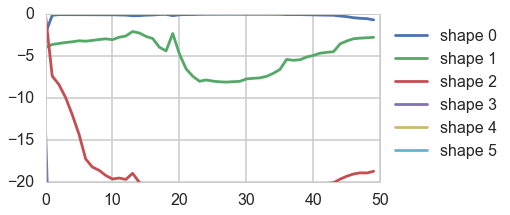

In [157]:
plt.figure(figsize=[6,3])
for i_shape in range(n_clusters):
    plt.plot([x[i_shape][-1] for x in log_prob_list], label='shape '+str(i_shape))
plt.ylim([-20, 0])
plt.legend(loc=0,bbox_to_anchor=[1,1])

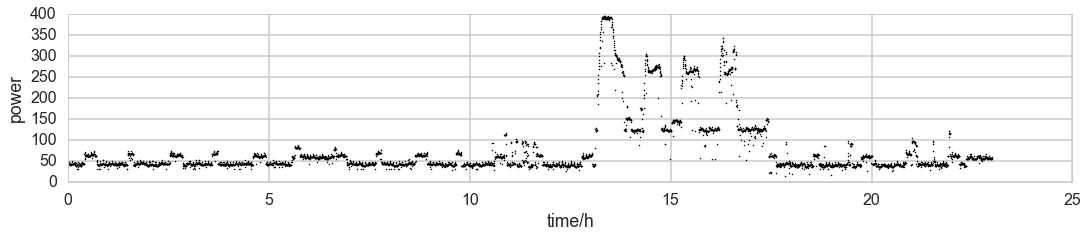

In [158]:
# example of read_dat_0819

t, dat = read_dat_0819(datetime.date(2016,4,1), 0, 23, '../new_data/IHG')

plt.figure(figsize=[18,3])
plt.plot(t, dat, 'k.', markersize=3)
plt.xlabel('time/h')
plt.ylabel('power')

In [159]:
%%time

para = {}
para['n_shape'] = n_clusters
para['delta_init'] = 200.
para['H'] = np.log(1-1./(15*4)) # 15 min per cp
para['delta_shape'] = delta_shape
para['Q'] = 100. # process error
para['R'] = 100. # measurement error
para['shape'] = cluster_mean

t, data = read_dat_0819(datetime.date(2016,4,1), 0, 23, '../new_data/IHG')

_, data = rel_change_filter_0819_3(range(len(data)), data)

log_prob, delta_mean, delta_var, time_since_last_cp = set_prior_3(para)
last_datum = 0

log_prob_list = []
delta_mean_list = []
delta_var_list = []
time_since_last_cp_list = []

for datum in data:
    log_prob, delta_mean, delta_var, time_since_last_cp = update_with_datum_3(datum, log_prob, delta_mean, delta_var, time_since_last_cp, last_datum, para)
    last_datum = datum

    log_prob_list.append(log_prob)
    delta_mean_list.append(delta_mean)
    delta_var_list.append(delta_var)
    time_since_last_cp_list.append(time_since_last_cp)


KeyboardInterrupt: 

In [143]:
def get_max_id(list_of_list):
    n_list = len(list_of_list)
    list_size = len(list_of_list[0])
    t = np.argmax(list_of_list)+1
    i_list = np.ceil(t / float(list_size)) - 1
    pos_in_list = t - i_list * list_size - 1

    return int(i_list), int(pos_in_list)

In [152]:
get_max_id(log_prob_list[300])

(0, 2)

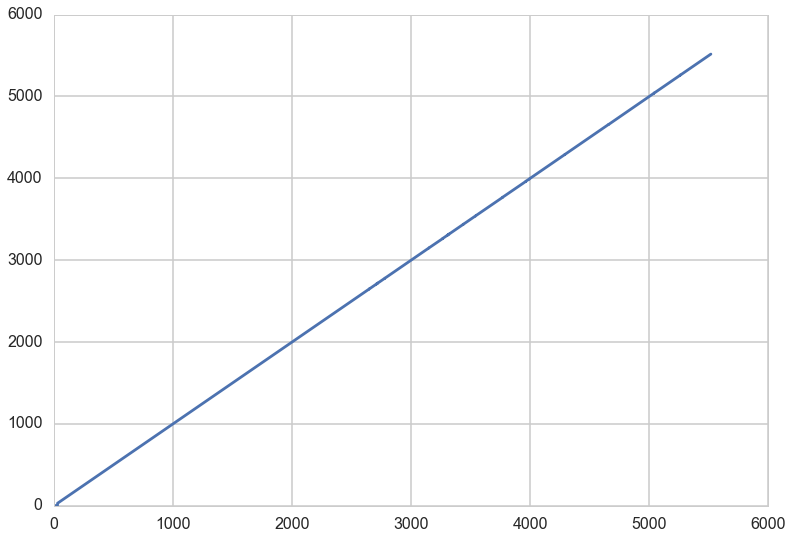

In [146]:
z = []
z2 = []
for i, (x, y) in enumerate(zip(log_prob_list, time_since_last_cp_list)):
    m, l = get_max_id(x)
    z.append( i-y[m][l] )
    z2.append(m)
plt.plot(z)